In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
import gc
from scipy import sparse
%matplotlib inline

In [2]:
df_train = pd.read_csv('data/sales_train.csv.gz', compression='gzip')
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
df_test_ = pd.read_csv('data/test.csv.gz', compression='gzip')
df_test_.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
df_item_bigcat = pd.read_csv('data/item_categories.csv')
l = list(df_item_bigcat.item_category_name)
l_cat = l
for ind in range(1,8): l_cat[ind] = 'Access'
for ind in range(10,18): l_cat[ind] = 'Consoles'
for ind in range(18,25): l_cat[ind] = 'Consoles Games'
for ind in range(26,28): l_cat[ind] = 'phone games'
for ind in range(28,32): l_cat[ind] = 'CD games'
for ind in range(32,37): l_cat[ind] = 'Card'
for ind in range(37,43): l_cat[ind] = 'Movie'
for ind in range(43,55): l_cat[ind] = 'Books'
for ind in range(55,61): l_cat[ind] = 'Music'
for ind in range(61,73): l_cat[ind] = 'Gifts'
for ind in range(73,79): l_cat[ind] = 'Soft'
df_item_bigcat['bigcat'] = l_cat
df_item_bigcat.head()

,item_category_name,item_category_id,bigcat
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


In [5]:
df_items = pd.read_csv('data/items.csv')
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
df_item_bigcat = df_item_bigcat.merge(df_items)
df_item_bigcat.drop(['item_category_name', 'item_name'], axis=1, inplace=True)
df_item_bigcat.head()

,item_category_id,bigcat,item_id
0,0,PC - Гарнитуры/Наушники,5441
1,0,PC - Гарнитуры/Наушники,16255
2,0,PC - Гарнитуры/Наушники,16256
3,0,PC - Гарнитуры/Наушники,16257
4,1,Access,5606


In [7]:
## Pivot by monht to wide format
df_train_piv = df_train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
df_train_piv.head()

date_block_num    0     1    2    3    4    5    6    7    8    9  ...    24  \
shop_id item_id                                                    ...         
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [8]:
df_train_piv.reset_index(inplace=True)

In [9]:
df_train_piv = df_train_piv.merge(df_item_bigcat, how="inner", on="item_id")
df_train_piv.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,item_category_id,bigcat
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,40,Movie
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie


In [10]:
# Encode Categories
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
df_train_piv[['bigcat']] = number.fit_transform(df_train_piv.bigcat)

In [11]:
# df_train_piv['shop_id']= df_train_piv['shop_id'].astype('category')
# df_train_piv['item_id']= df_train_piv['item_id'].astype('category')
# df_train_piv['bigcat']= df_train_piv.bigcat.astype('category')
# df_train_piv['item_category_id']= df_train_piv.item_category_id.astype('category')

In [12]:
df_train_piv = df_train_piv[['shop_id', 'item_id', 'item_category_id','bigcat'] + list(range(34))]
df_train_piv.head()

,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,7,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,40,7,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,40,7,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,40,7,0.0,4.0,5.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,40,7,0.0,7.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# %load_ext autoreload
# %autoreload 2
from gatzzt import downcast_dtypes
df_train_piv = downcast_dtypes(df_train_piv)

In [14]:
# from pandas.plotting import scatter_matrix
# scatter_matrix(df_train_piv.iloc[:, :10], alpha=0.2, figsize=(20, 20), diagonal='hist');

# Preprocess categories

In [15]:
# clip
df_train_piv.iloc[:, 4:] = df_train_piv.iloc[:, 4:].clip(0, 20)
df_train_piv.head()

,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,7,0.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,40,7,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,40,7,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,40,7,0.0,4.0,5.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,40,7,0.0,7.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df_cats = df_train_piv.iloc[:, :4]
df_cats.nunique()

shop_id                60
item_id             21807
item_category_id       84
bigcat                 20
dtype: int64

In [17]:
df_months = df_train_piv.iloc[:, 4:]
df_months.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
from sklearn.preprocessing import OneHotEncoder
onehot_enc = OneHotEncoder()
onehot_cols = df_cats.columns[df_cats.columns != 'item_id'].tolist()
X_onehot = onehot_enc.fit_transform(df_cats.loc[:, onehot_cols])

In [101]:
# import category_encoders as ce
# hash_cols = ['item_id']
# hash_enc = ce.HashingEncoder(cols=hash_cols, n_components=100)
# X_label = sparse.csr_matrix(hash_enc.fit_transform(df_cats.loc[:, hash_cols]).values)

In [51]:
def expanding_mean_encoding(df, group_cols, target_col=None):
    if not target_col:
        target_col = df.columns[-1]
    cumsum = df.groupby(group_cols)[target_col].cumsum() - df[target_col]
    cumcnt = df.groupby(group_cols)[target_col].cumcount()
    df['mean_encoding'] = cumsum / cumcnt
    df.fillna(0, inplace=True)
    return df[['mean_encoding']].values, df.loc[:, group_cols + ['mean_encoding']].groupby(group_cols).mean().to_dict()['mean_encoding']

In [52]:
mean_code, map_dict = expanding_mean_encoding(df_train_piv.loc[:, label_cols + [33]], label_cols, 33)

In [53]:
label_cols = ['item_id']
X_label = sparse.csr_matrix(mean_code)

# xgbost

In [54]:
param = {'max_depth':6, 
         'subsample':1,
         'colsample_bytree':1,
#          'min_child_weight':0.5,
         'eta':0.3, 
         'seed':1,
         'eval_metric':'rmse'}

In [55]:
def period_column_feats(X, period=12):
    n_col = X.shape[1]
    feats = []

    for i in range(12):
        cols = [i]
        j = 1
        while i + j * period < n_col:
            cols.append(i + j * period)
            j += 1
        feats.extend([X[:, cols].mean(axis=1), X[:, cols].max(axis=1), X[:, cols].min(
            axis=1), X[:, cols].std(axis=1), np.median(X[:, cols], axis=1)])
    return np.column_stack(feats)

In [56]:
n_months = 30
bsts = []

In [57]:
# train_cols = [-3, -2]
train_cols = [-4, -3]
for train_col in train_cols:
    X_train = sparse.csr_matrix(df_months.iloc[:, train_col - n_months:train_col].values)
    X_train = sparse.hstack((X_onehot, X_label, X_train))

    y_train = df_months.iloc[:, train_col].values
    if train_col == train_cols[0]:
        X_train_cum, y_train_cum = X_train, y_train
    else:
        X_train_cum = sparse.vstack((X_train_cum, X_train))
        y_train_cum = np.concatenate((y_train_cum, y_train))
        
print(X_train_cum.shape)

(848248, 195)


In [58]:
# # train_cols = [-3, -2, -1]
# train_cols = [-3]
# for train_col in train_cols:
#     X_train = df_months.iloc[:, train_col - n_months:train_col].values
#     X_train = np.concatenate((df_cats.values, X_train), axis=1)
#     # X_train_period = period_column_feats(X_train)
#     # X_train = np.concatenate((X_train, X_train_period), axis=1)
#     # X_train_diff = df_months.iloc[:, train_col - n_months:train_col].diff(axis=1).values
#     # X_train = np.concatenate((X_train, X_train_diff), axis=1)

#     y_train = df_months.iloc[:, train_col].values
#     if train_col == train_cols[0]:
#         X_train_cum, y_train_cum = X_train, y_train
#     else:
#         X_train_cum = np.concatenate((X_train_cum, X_train), axis=0)
#         y_train_cum = np.concatenate((y_train_cum, y_train))
        
# print(X_train_cum.shape)

In [59]:
val_col = train_cols[-1] + 1
X_val = sparse.csr_matrix(df_months.iloc[:, val_col - n_months:val_col].values)
X_val = sparse.hstack((X_onehot, X_label, X_val))
y_val = df_months.iloc[:, val_col].values

In [60]:
xgbtrain = xgb.DMatrix(X_train_cum, y_train_cum)
xgbval = xgb.DMatrix(X_val, y_val)
watchlist  = [(xgbtrain,'train'), (xgbval,'val')]
bst = xgb.train(param, xgbtrain, num_boost_round=35,evals=watchlist, early_stopping_rounds=10)
bsts.append(bst)
del X_train, X_val, y_train, y_val, xgbtrain, xgbval
gc.collect()

[0]	train-rmse:0.707015	val-rmse:0.800743
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.631451	val-rmse:0.737843
[2]	train-rmse:0.587425	val-rmse:0.704037
[3]	train-rmse:0.563154	val-rmse:0.686624
[4]	train-rmse:0.548625	val-rmse:0.676962
[5]	train-rmse:0.539771	val-rmse:0.672667
[6]	train-rmse:0.533469	val-rmse:0.671464
[7]	train-rmse:0.52957	val-rmse:0.670011
[8]	train-rmse:0.52657	val-rmse:0.668904
[9]	train-rmse:0.524503	val-rmse:0.668925
[10]	train-rmse:0.522688	val-rmse:0.6684
[11]	train-rmse:0.520725	val-rmse:0.668104
[12]	train-rmse:0.519144	val-rmse:0.667738
[13]	train-rmse:0.517791	val-rmse:0.667755
[14]	train-rmse:0.516624	val-rmse:0.66797
[15]	train-rmse:0.515374	val-rmse:0.66781
[16]	train-rmse:0.514626	val-rmse:0.668218
[17]	train-rmse:0.51399	val-rmse:0.668057
[18]	train-rmse:0.513215	val-rmse:0.668852
[19]	train-rmse:0.512587	val-rmse:0.66981
[20]	train-rmse:0

1662

In [61]:
last_col = -1
X_last = sparse.csr_matrix(df_months.iloc[:, last_col - n_months:last_col].values)
X_last = sparse.hstack((X_onehot, X_label, X_last))
y_last = df_months.iloc[:, last_col].values

In [62]:
xgblast = xgb.DMatrix(X_last)
preds = bst.predict(xgblast, ntree_limit=bst.best_ntree_limit)
np.sqrt(mean_squared_error(y_last, preds))

0.74058586

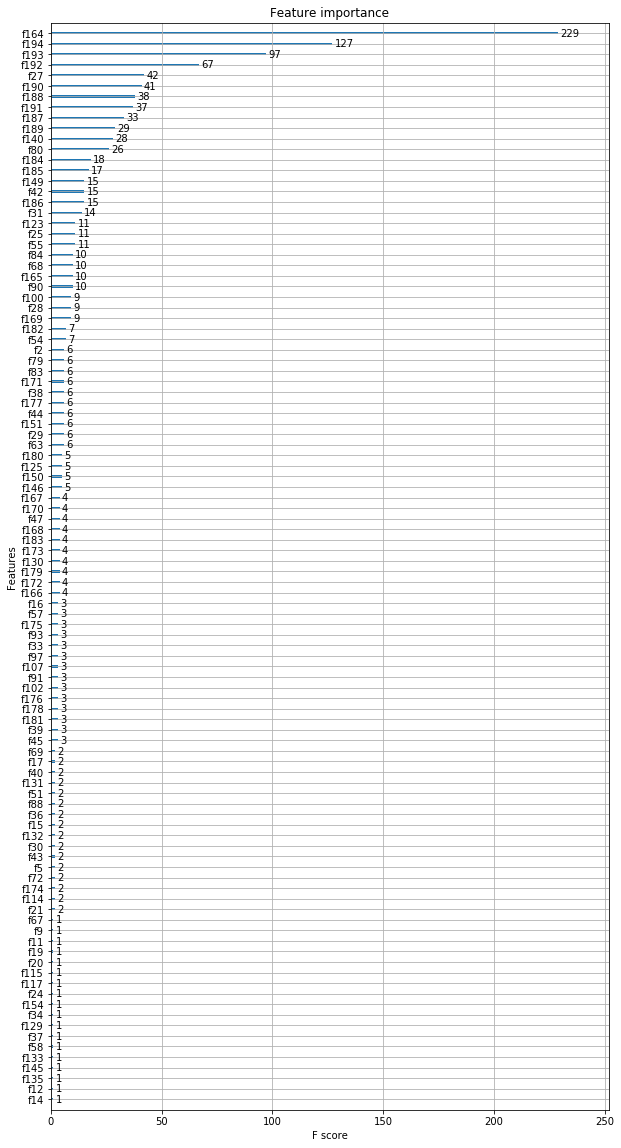

In [63]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

my_plot_importance(bst, figsize=(10, 20))

In [64]:
df_test = df_test_

df_test = df_test.merge(df_train_piv, how = "left", on = ["shop_id", "item_id"]).fillna(0)
df_test.head()

,ID,shop_id,item_id,item_category_id,bigcat,0,1,2,3,4,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,23.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
X_test_label = sparse.csr_matrix(df_test[label_cols[0]].map(map_dict))

In [73]:
X_test_label = X_test_label.transpose()

In [74]:
X_test = sparse.csr_matrix(df_test.iloc[:, -n_months:].values)
X_test_onehot = onehot_enc.transform(df_test.loc[:, onehot_cols])


X_test = sparse.hstack((X_test_onehot, X_test_label, X_test))

In [75]:
X_train_cum.shape

(848248, 195)

In [76]:
X_test.shape

(214200, 195)

In [77]:
xgbtest = xgb.DMatrix(X_test)

In [78]:
preds = []
for bst in bsts:
    preds.append(bst.predict(xgbtest, ntree_limit=bst.best_ntree_limit))

In [79]:
preds = np.column_stack(preds)
preds = np.mean(preds, axis=1)
preds = np.clip(preds, 0, 20)

In [80]:
# Normalize prediction to [0-20]
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds })
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

In [81]:
sub_df.head()

,ID,item_cnt_month
0,0,0.683125
1,1,0.015575
2,2,1.645519
3,3,0.397078
4,4,0.015575


# Random Forest

In [25]:
X = df_train_piv.iloc[:,  (df_train_piv.columns != 33)].values
y = df_train_piv.iloc[:, df_train_piv.columns == 33].values.ravel()
shopids = df_train_piv['shop_id'].values

In [41]:


# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
# train_index, val_index = next(skf.split(X, shopids))
# X_train, y_train = X[train_index], y[train_index]
# X_val, y_val = X[val_index], y[val_index]



# # X, y = sklearn.datasets.load_digits(10,True)
# X_train, X_val, y_train, y_val = train_test_split(X, y)

In [47]:
# from sklearn.ensemble import RandomForestRegressor

# n_estimators = 100
# rf = RandomForestRegressor(warm_start=True, criterion='mse', n_jobs=-1)

# train_scores = []
# val_scores = []
# for i in range(1, n_estimators + 1):
#     rf.set_params(n_estimators=i)
#     rf.fit(X_train, y_train)
#     train_pred = rf.predict(X_train)
#     val_pred = rf.predict(X_val)
#     train_score = np.sqrt(mean_squared_error(train_pred, y_train))
#     val_score = np.sqrt(mean_squared_error(val_pred, y_val))                    
#     print(i, train_score, val_score)

In [44]:
df_test = df_test_.copy()
df_test['shop_id']= df_test_.shop_id.astype('str')
df_test['item_id']= df_test_.item_id.astype('str')

df_test = df_test.merge(df_train_piv, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
df_test.head()

,ID,shop_id,item_id,bigcat,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
d = dict(zip(df_test.columns[4:],list(np.array(list(df_test.columns[4:])) - 1)))
df_test  = df_test.rename(d, axis = 1)
df_test.head()

,ID,shop_id,item_id,bigcat,-1,0,1,2,3,4,...,23,24,25,26,27,28,29,30,31,32
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
preds = rf.predict(df_test.iloc[:, (df_test.columns != 'ID') & (df_test.columns != -1)].values)

# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':df_test.ID,'item_cnt_month': preds })
from datetime import datetime

sub_df.to_csv('submission/xgboost_{}.csv'.format(datetime.now().strftime('%Y-%m-%d %H-%M-%S')),index=False)

In [ ]:
kaggle competitions submit -c competitive-data-science-final-project -f submission.csv -m "Message"